In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [ ]:
#df = pd.read_csv("examples.csv")
df = pd.read_csv("updated_examples.csv")

In [ ]:
df

,sentence,question,set_id,type,answer,correct_option,incorrect_option
0,The child that the neighbor that the guest scared liked fell.,Who did the guest scare?,s1,second_center,The neighbor,neighbor,child
1,The child that the neighbor that the guest scared liked fell.,Who did the neighbor like?,s1,first_center,The child,child,guest
2,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the guest scare?,s1,second_center_nd,The neighbor,neighbor,child
3,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the neighbor like?,s1,first_center_nd,The child,child,guest
4,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the guest scare?,s1,second_center_sim,The neighbor,neighbor,child
5,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the neighbor like?,s1,first_center_sim,The child,child,guest
6,The man that the investigator that the journalist admired checked laughed.,Who did the journalist admire?,s2,second_center,The investigator,investigator,man
7,The man that the investigator that the journalist admired checked laughed.,Who did the investigator check?,s2,first_center,The man,man,journalist
8,"The man, who was checked by the investigator admired by the journalist, laughed.",Who did the journalist admire?,s2,second_center_nd,The investigator,investigator,man
9,"The man, who was checked by the investigator admired by the journalist, laughed.",Who did the investigator check?,s2,first_center_nd,The man,man,journalist


In [ ]:
!pip install fastchat pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
MODEL_NANE = "lmsys/vicuna-7b-v1.3"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [ ]:
def generate_prompt(sentence, question):
    prompt = (
    f"Sentence: The capital of France is one of the most visited cities in the world.\n"
    f"Question: What is the capital of France?\n"
    f"Answer: Paris\n\n"
    f"Sentence: Water is composed of two hydrogen atoms and one oxygen atom.\n"
    f"Question: What is the chemical symbol for water?\n"
    f"Answer: H₂O\n\n"
    f"Sentence: The Earth is divided into large landmasses known as continents.\n"
    f"Question: How many continents are there on Earth?\n"
    f"Answer: Seven\n"
    f"Sentence: {sentence}\n"
    f"Question: {question}\n"
    f"Answer: The")

    return prompt

In [ ]:
def predict_answer(model, tokenizer, sentence, correct_option, incorrect_option, question, num_tokens=5):
    prompt = generate_prompt(sentence, question)
    input_ids_sentence = tokenizer(prompt, return_tensors="pt").input_ids.to(DEVICE)
    correct_tokens = tokenizer(correct_option, return_tensors="pt").input_ids.squeeze()
    incorrect_tokens = tokenizer(incorrect_option, return_tensors="pt").input_ids.squeeze()

    # Get the possible token IDs (correct and incorrect tokens)
    correct_token_ids = correct_tokens.tolist()
    incorrect_token_ids = incorrect_tokens.tolist()

    # Initialize the predicted tokens list with the sentence input
    generated_ids = input_ids_sentence
    answer_ids = tokenizer.encode("The")

    # here we are generting sequence in num_tokens length, to handle multiple tokens answers
    # in the accuracy calculation we will ceck only the first token of the answer
    for _ in range(num_tokens):
        with torch.no_grad():
            outputs = model(generated_ids).logits

        next_token_logits = outputs[:, -1, :]

        # Extract logits only for the tokens in correct and incorrect options
        valid_token_ids = correct_token_ids + incorrect_token_ids
        next_token_logits_valid = next_token_logits[:, valid_token_ids]

        # Find the argmax of the valid token logits
        predicted_token_id = valid_token_ids[torch.argmax(next_token_logits_valid)]

        predicted_token_id_tensor = torch.tensor([[predicted_token_id]], device=generated_ids.device)
        answer_ids.append(predicted_token_id)
        generated_ids = torch.cat((generated_ids, predicted_token_id_tensor), dim=-1)

    predicted_text = tokenizer.decode(answer_ids, skip_special_tokens=True)
    return predicted_text

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NANE)
if tokenizer.pad_token_id is None:
   tokenizer.pad_token_id = tokenizer.eos_token_id

model = AutoModelForCausalLM.from_pretrained(MODEL_NANE, torch_dtype=torch.float16)
model.to(DEVICE)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggin

config.json:   0%|          | 0.00/566 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
      

### Predict and calculate accuracy

In [ ]:
def predict_and_calculate_accuracy(model, tokenizer, data_df, print=False):
    correct_predictions = 0
    total_predictions = 0

    for index, row in data_df.iterrows():
        sentence = row['sentence']
        correct_option = row['correct_option']
        incorrect_option = row['incorrect_option']
        true_answer = row['answer']
        question = row['question']

        predicted_answer = predict_answer(model, tokenizer, sentence, correct_option, incorrect_option, question)
        if print:
          print(f"Sentence: {sentence}")
          print(f"Correct Option: {correct_option}")
          print(f"Incorrect Option: {incorrect_option}")
          print(f"True Answer: {true_answer}")
          print(f"Predicted Answer: {predicted_answer}")

        if predicted_answer.startswith(true_answer):
            correct_predictions += 1
            if print:
              print("Correct prediction!")
        else:
            if print:
              print("Incorrect prediction.")

        if print:
          print("-" * 50)

        total_predictions += 1

    return correct_predictions, total_predictions

def calc_accuracy(correct_predictions, total_predictions, print=False):
    accuracy = correct_predictions / total_predictions * 100
    if print:
      print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

### Seperate to datarames according to type and wording

In [ ]:
# Compare according to locations - in first wording (com)
df_first = df[df["type"] == "first_center"]
correct_predictions_first, total_predictions_first = predict_and_calculate_accuracy(model, tokenizer, df_first)

df_second = df[df["type"] == "second_center"]
correct_predictions_second, total_predictions_second = predict_and_calculate_accuracy(model, tokenizer, df_second)

# Compare according to locations - in second wording (nd)
df_first_nd = df[df["type"] == "first_center_nd"]
correct_predictions_first_nd, total_predictions_first_nd = predict_and_calculate_accuracy(model, tokenizer, df_first_nd)

df_second_nd = df[df["type"] == "second_center_nd"]
correct_predictions_second_nd, total_predictions_second_nd = predict_and_calculate_accuracy(model, tokenizer, df_second_nd)

# Compare according to locations - in third wording (sim)
df_first_sim = df[df["type"] == "first_center_sim"]
correct_predictions_first_sim, total_predictions_first_sim = predict_and_calculate_accuracy(model, tokenizer, df_first_sim)

df_second_sim = df[df["type"] == "second_center_sim"]
correct_predictions_second_sim, total_predictions_second_sim = predict_and_calculate_accuracy(model, tokenizer, df_second_sim)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


### Plot functions

In [99]:
def plot_acc(names, values, title, xlabels):
  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(8, 6))

  # Create the barplot
  bars = ax.bar(names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], edgecolor='black', alpha=0.85)

  # Add the accuracy values on top of the bars
  for bar in bars:
      height = bar.get_height()
      ax.annotate(f'{height:.2f}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),  # Place the text at the top of the bar
                  xytext=(0, 3),  # Slightly above the bar
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

  # Set the title and labels
  ax.set_title(title, fontsize=16, fontweight='bold')
  ax.set_xlabel(xlabels, fontsize=14)
  ax.set_ylabel('Accuracy', fontsize=14)

  # Improve layout and aesthetics
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_color('#4c4c4c')
  ax.spines['bottom'].set_color('#4c4c4c')
  ax.yaxis.grid(True, linestyle='--', color='gray', alpha=0.7)

  plt.tight_layout()

  # Save the plot
  filename = title.lower().replace(' ', '_') + '.png'
  plt.savefig(filename)

  # Show the plot
  plt.show()

In [ ]:
def plot_grouped_barplot(categories, group_values, group_labels, xlabel, title):
    """
    Function to create a grouped bar plot for categories with multiple groups of values.

    Parameters:
    - categories: A list of categories (e.g., different items, labels, etc.).
    - group_values: A list of lists, where each sublist contains values for a specific group.
                    Each sublist should correspond to a single group across all categories.
    - group_labels: A list of labels corresponding to each group.

    Example:
    plot_grouped_barplot(['Category 1', 'Category 2'], [[1.97, 0.61], [0.61, 0.51]], ['Group 1', 'Group 2'])
    """

    # Number of categories and number of groups
    n_categories = len(categories)
    n_groups = len(group_values)

    # Make sure the number of group values matches the number of labels
    assert n_groups == len(group_labels), "The number of group value sets must match the number of group labels"

    # Create bar width and position for grouped bars
    bar_width = 0.8 / n_groups  # Adjust bar width based on the number of groups
    index = np.arange(n_categories)

    # Plotting
    fig, ax = plt.subplots()

    # Loop through each group and plot its bars
    bars = []
    for i in range(n_groups):
        bars.append(ax.bar(index + i * bar_width, group_values[i], bar_width, label=group_labels[i]))

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    ax.set_title(title)
    ax.set_xticks(index + bar_width * (n_groups - 1) / 2)
    ax.set_xticklabels(categories)

    # Increase y-axis limit for better spacing
    max_value = max([max(group) for group in group_values])
    ax.set_ylim(0, max_value * 1.4)  # Set y-limit a bit higher than the maximum value to allow space for labels

    # Add legend
    ax.legend()

    # Optionally add values above bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    for bar_group in bars:
        add_labels(bar_group)

    # Display the plot
    plt.tight_layout()

    # Save the plot
    filename = title.lower().replace(' ', '_') + '.png'
    plt.savefig(filename)

    # Show the plot after saving
    plt.show()


### Plots

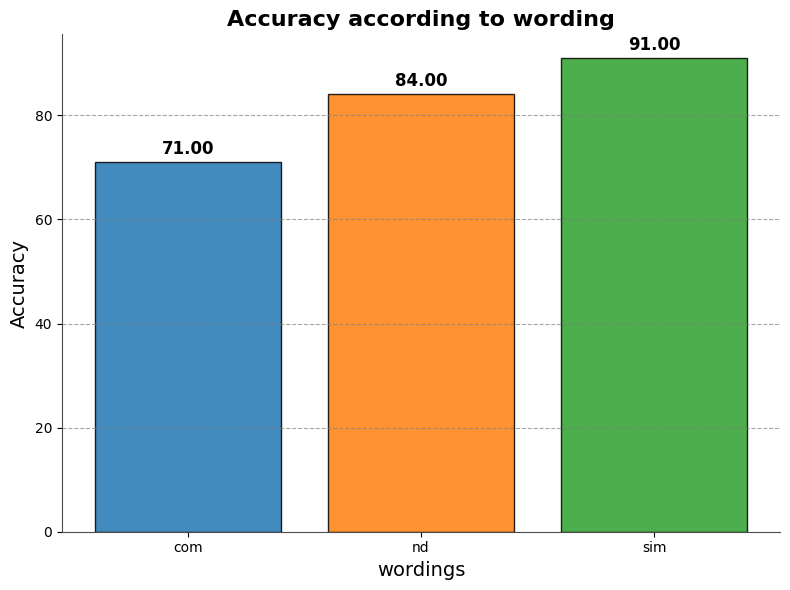

In [100]:
# Compare accuracy between different wordings

acc = calc_accuracy(correct_predictions_first + correct_predictions_second, total_predictions_first + total_predictions_second)
acc_nd = calc_accuracy(correct_predictions_first_nd + correct_predictions_second_nd, total_predictions_first_nd + total_predictions_second_nd)
acc_sim = calc_accuracy(correct_predictions_first_sim + correct_predictions_second_sim, total_predictions_first_sim + total_predictions_second_sim)

plot_acc(["com", "nd", "sim"], [acc, acc_nd, acc_sim], "Accuracy according to wording", "wordings")

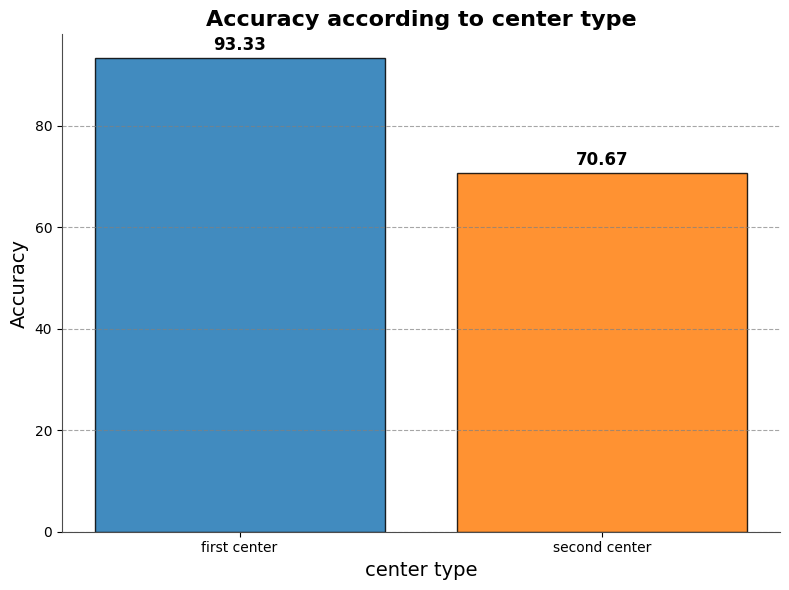

In [101]:
# Compare according to different types
acc_first = calc_accuracy(correct_predictions_first + correct_predictions_first_nd + correct_predictions_first_sim,
                          total_predictions_first + total_predictions_first_nd + total_predictions_first_sim)

acc_second = calc_accuracy(correct_predictions_second + correct_predictions_second_nd + correct_predictions_second_sim,
                          total_predictions_second + total_predictions_second_nd + total_predictions_second_sim)

plot_acc(["first center", "second center"], [acc_first, acc_second], "Accuracy according to center type", "center type")

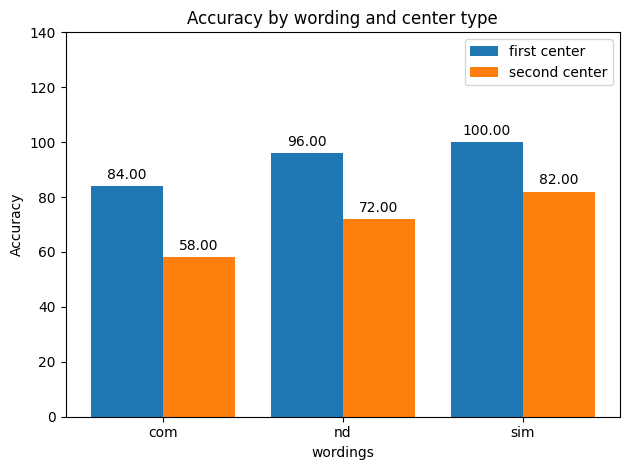

In [ ]:
# Draw a plot of accuracy by wording category and center type as group
wordings = ['com', 'nd', 'sim']
types = ["first center", "second center"]
accuracy_type_1 = [calc_accuracy(correct_predictions_first, total_predictions_first),
                   calc_accuracy(correct_predictions_first_nd, total_predictions_first_nd),
                   calc_accuracy(correct_predictions_first_sim, total_predictions_first_sim)]

accuracy_type_2 = [calc_accuracy(correct_predictions_second, total_predictions_second),
                   calc_accuracy(correct_predictions_second_nd, total_predictions_second_nd),
                   calc_accuracy(correct_predictions_second_sim, total_predictions_second_sim)]

values = [accuracy_type_1, accuracy_type_2]
plot_grouped_barplot(wordings, values, types, "wordings", "Accuracy by wording and center type")

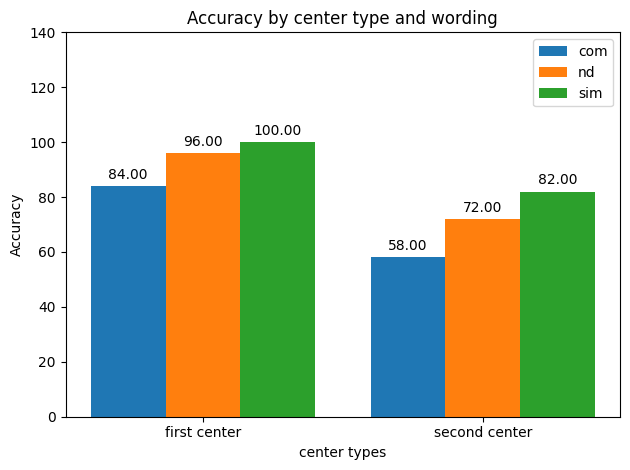

In [ ]:
# Draw a plot of accuracy by center type as category and wording as group
wordings = ['com', 'nd', 'sim']
center_types = ["first center", "second center"]

accuracy_com = [calc_accuracy(correct_predictions_first, total_predictions_first), #type 1
                   calc_accuracy(correct_predictions_second, total_predictions_second)] #type 2

accuracy_nd = [calc_accuracy(correct_predictions_first_nd, total_predictions_first_nd), #type 1
                   calc_accuracy(correct_predictions_second_nd, total_predictions_second_nd)] #type 2

accuracy_sim = [calc_accuracy(correct_predictions_first_sim, total_predictions_first_sim), #type 1
                   calc_accuracy(correct_predictions_second_sim, total_predictions_second_sim)] #type 2


values = [accuracy_com, accuracy_nd, accuracy_sim]
plot_grouped_barplot(types, values, wordings, "center types", "Accuracy by center type and wording")